### ACO (Ant Colony Optimization) algorithm for TSP

The code below uses ACO to determine the shortest tour between `num_nodes` nodes that are
<br> randomly generated. <br><br>ACO, like Genetic Algorithms, is a heuristic based algorithm. <br>
It does not guarantee optimality, but near optimal solutions (which maybe acceptable for a particular problem)

In [1]:
num_nodes = 10

In [2]:
import networkx as nx
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
from statistics import mean

In [3]:
np.seterr(divide='ignore', invalid='ignore')
None

### Generate random X and Y coordinates

In [4]:
xs = [np.random.randint(100, 1000) for _ in range(num_nodes)]
ys = [np.random.randint(100, 1000) for _ in range(num_nodes)]

### Generate the distances between all nodes

In [5]:
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt(math.pow(x1-x2, 2) + math.pow(y1-y2, 2))

distance_matrix = np.array([
        distance((xs[i], ys[i]), (xs[j], ys[j])) for i in range(num_nodes) for j in range(num_nodes)
    ]).reshape(num_nodes,num_nodes)

distance_df = pd.DataFrame(distance_matrix)
distance_df.head(3)


,0,1,2,3,4,5,6,7,8,9
0,0.000000,240.682363,181.011049,350.052853,490.987780,317.515354,154.353490,708.661414,645.458752,552.580311
1,240.682363,0.000000,72.780492,412.510606,262.923943,135.085158,392.200204,487.496667,591.943409,599.964166
2,181.011049,72.780492,0.000000,415.735493,335.574135,197.517088,327.123830,560.260654,632.790645,612.698947


### Graph for ACO

In [6]:
G = nx.Graph()
for u in distance_df.index:
    for v in distance_df.columns:
        G.add_edge(u, v, distance=distance_df.loc[u,v])
        
pos = nx.spring_layout(G)
edge_labels = {
    (r, c): round(distance_df.loc[r,c], 4) for r in distance_df.index for c in distance_df.columns if r != c and r > c
}

### ACO parameters

In [7]:
max_iterations = 100
num_ants = 20
tau_0 = (10/(num_nodes * mean(edge_labels.values()))) # initial pheromone concentration
tau_matrix = tau_0 * np.ones((num_nodes, num_nodes))
np.fill_diagonal(tau_matrix, 0)
tau_df = pd.DataFrame(tau_matrix)
eta_matrix= 1 / distance_matrix
eta_df = pd.DataFrame(eta_matrix)

rho = 0.05 # evaporation rate .. this determines how much pheromones are lost at each iteration
alpha = 1 # pheromone exponential parameter
beta = 1 # desirability exponential parameter

### ACO functions

In [8]:
def roulette_wheel(probabilty_vector):
    cumulative_sum = np.cumsum(probabilty_vector)
    r = np.random.rand()
    return np.where(r <= cumulative_sum)[0][0]
    
def create_colony(graph, colony, num_ants, tau_matrix, eta_matrix, alpha, beta):
    num_nodes = len(graph.nodes)
    ant_tours = np.empty((0, num_nodes + 1), dtype=int)
    for i in range(num_ants):
        current_tour = []
        initial_node = random.randint(0, num_nodes-1)
        current_tour = [initial_node]
        
        for j in range(1, num_nodes):
            current_node = current_tour[-1]
            probabilty_all_nodes = tau_matrix[current_node,:]**alpha * (eta_matrix[current_node,:] ** beta)
            for node in current_tour:
                probabilty_all_nodes[node] = 0
            probabilty_all_nodes_sum = np.nansum(probabilty_all_nodes)
            probabilty_vector = probabilty_all_nodes / probabilty_all_nodes_sum
            
            next_node = roulette_wheel(probabilty_vector)
            current_tour.append(next_node)
        
        current_tour.append(current_tour[0])
        ant_tours = np.vstack((ant_tours, np.array(current_tour)))
    
    return ant_tours


def tour_distance(tour, graph):
    distance = 0
    for i in range(len(tour) - 1):
        distance += graph.edges[tour[i], tour[i+1]]['distance']
    return distance

def update_pheromones(tau_matrix, tour_and_distance):
    num_ants = tour_and_distance.shape[0]
    num_nodes = tour_and_distance.shape[1] - 1
    for i in range(num_ants):
        for j in range(num_nodes - 1):
            current_node = int(tour_and_distance[i, j])
            next_node = int(tour_and_distance[i, j + 1])
            tau_matrix[current_node, next_node] = tau_matrix[current_node, next_node] + (1/tour_and_distance[i, -1])
            tau_matrix[next_node, current_node] = tau_matrix[next_node, current_node] + (1/tour_and_distance[i, -1])

    

### Main loop of ACO

In [9]:
shortest_tour_length = float('inf')
all_solutions = np.empty((0, 2))

for i in range(0, max_iterations):
    # create the tours for all ants
    tours = create_colony(G, [], num_ants, tau_matrix, eta_matrix, alpha, beta)

    # calculate the tour length for each tour
    tour_lengths = np.array([tour_distance(tours[row,:], G) for row in range(tours.shape[0])]).reshape(num_ants, 1)
    tour_and_distance = np.hstack((tours, tour_lengths))
    
    # find the best ant (queen)
    current_shortest_length = np.amin(tour_and_distance[:, -1])
    current_best_ant = np.where(tour_and_distance[:, -1] == current_shortest_length)[0][0]
    current_shortest_tour = tour_and_distance[current_best_ant, :-1]

    # update the shortest tour found so far
    if current_shortest_length < shortest_tour_length:
        shortest_tour_length = current_shortest_length
        best_tour = current_shortest_tour
        
    # update the pheromone matrix
    update_pheromones(tau_matrix, tour_and_distance)
    
    # evaporation
    tau_matrix = (1 - rho) * tau_matrix

    # capture the results
    all_solutions = np.vstack((all_solutions, np.array([i, current_shortest_length])))

### Shortest Path Length

In [10]:
f'Shorest path length is {shortest_tour_length}'

'Shorest path length is 2382.6848786810633'

### Plot the best result of each iteration

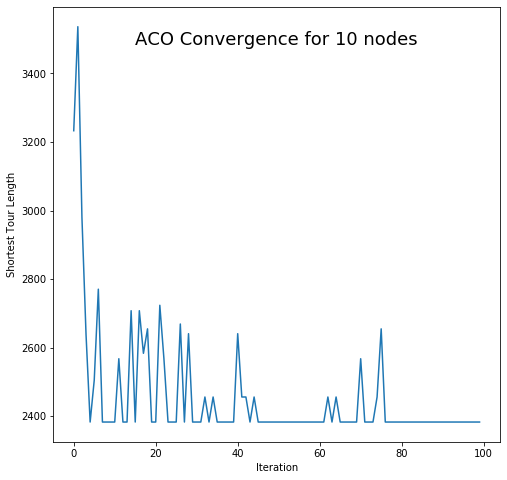

In [11]:
plt.figure(figsize=(8, 8))
plt.title(f'ACO Convergence for {num_nodes} nodes', fontdict={'fontsize': 18}, x=0.5, y=.90)
plt.plot(all_solutions[:, 0], all_solutions[:, 1])
plt.xlabel('Iteration')
plt.ylabel('Shortest Tour Length')
None

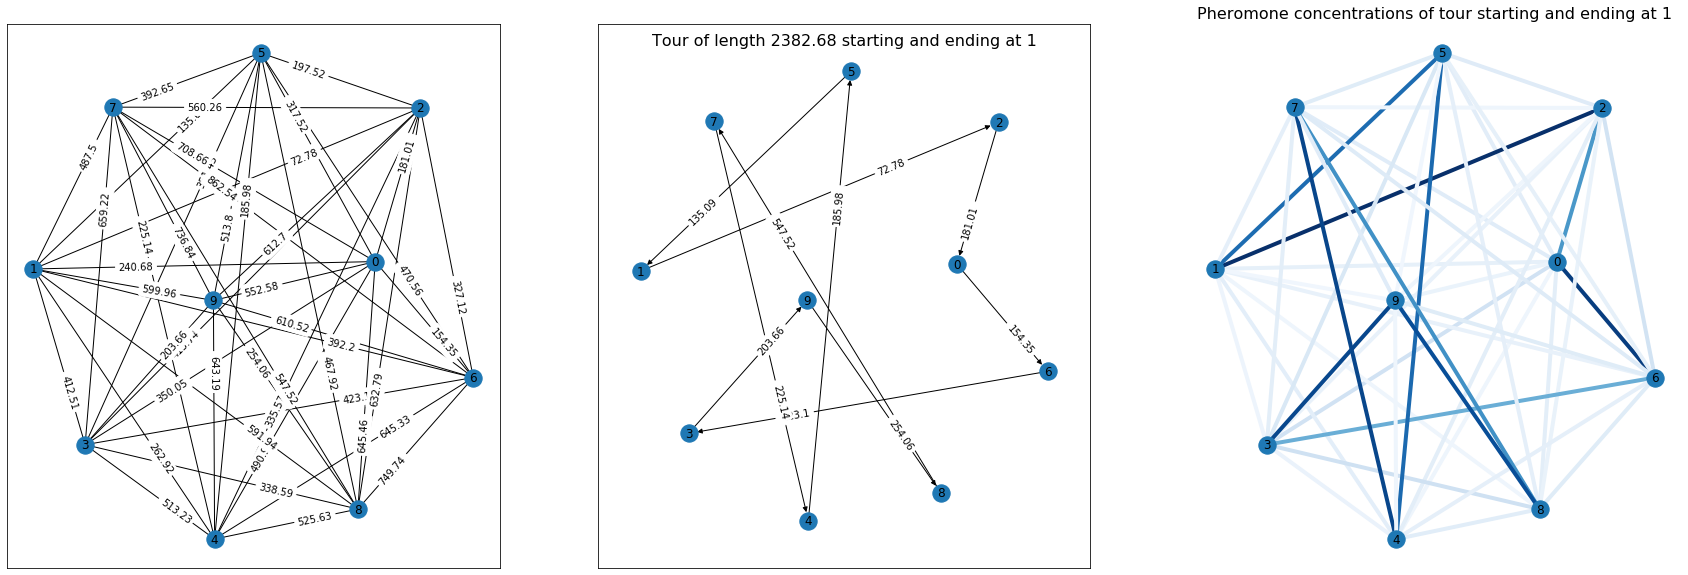

In [12]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
G = nx.Graph()
for u in distance_df.index:
    for v in distance_df.columns:
        G.add_edge(u, v, distance=distance_df.loc[u,v])
        
pos = nx.spring_layout(G)
edge_labels = {
    (r, c): round(distance_df.loc[r,c], 2) for r in distance_df.index for c in distance_df.columns if r != c and r > c
}
nx.draw_networkx(G, pos)
ret = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.7)

plt.subplot(1,3,2)
best_tour = best_tour.astype(int)
# plt.figure(figsize=(15,10))
plt.title(f'Tour of length {round(shortest_tour_length, 2)} starting and ending at {best_tour[0]}', fontdict={'fontsize': 16}, y=0.95)
H = nx.DiGraph()
edge_labels = {}
for i in range(num_nodes):
    H.add_edge(best_tour[i], best_tour[i + 1])
    edge_labels[best_tour[i], best_tour[i + 1]] = round(distance_matrix[best_tour[i], best_tour[i + 1]], 2)
nx.draw_networkx(H, pos)
ret = nx.draw_networkx_edge_labels(H, pos=pos, edge_labels=edge_labels, label_pos=0.3)

plt.subplot(1,3,3)
plt.title(f'Pheromone concentrations of tour starting and ending at {best_tour[0]}', fontdict={'fontsize': 16})
nx.draw(G, pos, width=4, edge_cmap=plt.cm.Blues, edge_color=[tau_matrix[u,v] for u, v in G.edges])
nx.draw_networkx_labels(G, pos)
None